In [1]:
import numpy as np, xrft

from scipy import signal, sparse, linalg

from scipy.sparse.linalg import svds

import datetime, os, glob, matplotlib, xarray as xr, numpy as np, dask.array as da, pandas as pd

import matplotlib.pyplot as plt, matplotlib.colors as colors, matplotlib.dates as mdates

from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=1, threads_per_worker=12)

client = Client(cluster)

In [2]:
ds = xr.open_mfdataset("/home/fcampos/ssh_2000-2018_v02.nc",
                       parallel=True,
                      ).transpose("longitude", "latitude", "time")
ds = ds#-ds.mean(dim="time")

## complex emphirical orthogonal functions
## 1) standarization of data: 
## remove time mean of data and divide by standard deviation in space:
## F$_{(s,t)}$ = $\dfrac{\Phi_{(s,t)}-\overline{\Phi}_{(s,t)}}{\sigma_{s}}$

## 2) expressing the standarized data in Hilbert space: 

## 3) computing CEOF via single value decomposition (SVD):
## F = U$*$S$*$V$^{+}$
## $\mathbf{note:}$ in my code I am using a version of SVD that use num modes for economizing the computation

## 4) computing Principal components and complex EOF: 
## principal component are definded as PC = U$*$S
## complex EOF are defined as EOF = V
## 5) computing phase and amplitude of PC and EOF (remember that PC and EOF are complex numbers):
## PC$^{mode}_{(t)}$ = A$^{mode}_{(t)}$ $e^{i \Psi^{mode}_{(t)}}$
## then, A$^{mode}_{(t)}$ = |PC$^{mode *}_{(t)}$ PC$^{mode}_{(t)}$|$^{1/2}$ and $\Psi^{mode}_{(t)}$ = $atan(\dfrac{Im[PC^{mode}_{(t)}]}{Re[PC^{mode}_{(t)}]})$

## EOF$^{mode}_{(s)}$ = B$^{mode}_{(s)}$ $e^{i \Phi^{mode}_{(s)}}$
## then, B$^{mode}_{(s)}$ = |EOF$^{mode *}_{(s)}$ EOF$^{mode}_{(s)}$|$^{1/2}$ and $\Psi^{mode}_{(s)}$ = $atan(\dfrac{Im[EOF^{mode}_{(s)}]}{Re[EOF^{mode}_{(s)}]})$

## 5) reconstructing denoised time serie:
## F'$_{(s,t)}$ = $\sum\limits_{k=1}^{k=m}$ PC$^{k}_{(t)}$*EOF$^{k+}_{s}$


In [3]:
"""
##########################################################################
#    Code for computing Complex Empirical Ortoghonal Functions (CEOF)    #
#                                                                        #
#    input:                                                              #
#        data: dimensions [longitude,latitude,time]                      #
#        num: maximum number of modes used for the analysis              #
#        modes: used for the reconstruction of denoised data             #
#        reconstructed: True -> save denoised data                       #
#                       False -> do not save denoised data               #
#    output:                                                             #
#        tamp: amplitude associated to the num principal components      #     
#        tpha: phase associated to the num principal components          #
#        camp: amplitude associated to the num eofs                      #
#        cpha: phase associated to the num eofs                          #
#        expvar: explained variance for num modes                        #
#        mat_rec: reconstructed matrix with m modes                      #
#    reader could check Venegas (2001):                                  #
#    https://www.atmos.colostate.edu/~davet/AT655/notes/VenegasNotes.pdf #
##########################################################################
"""
def ceof(data,num=10,modes=10, reconstructed=True):   
    # number of points in spatial and time:
    nx, ny, nt = data.shape    
    # reshaping in a spatial and time matrix: data[spatial,time]
    data = np.reshape(data, (nx*ny, nt)).T
    # creating a mask for land
    index = ~np.isnan(data[0])
    # holding only not-nan values in space
    ndata = data[:,index]
    # spatial (without land) and time point of grids
    tt, xx = ndata.shape
    # standarization of data according Venegas (2001)
    ndata = signal.detrend(ndata, axis = 0, type = "constant")/np.std(ndata, axis=1)[:,None]
    # Hilbert transformation for the standarized data 
    F = signal.hilbert(ndata)
    # single value decomposition (SVD method) using only "num" modes. Generally, the first ten modes cover overall variability 
    u, s, vT = svds(F, k=num)
    # computing complex pc and eof
    PC, EOF = np.dot(u,np.diag(s)), vT.T
    # amplitude and phase for principal components (PC) and eof's
    tamp, tpha = np.sqrt(abs(PC)), np.angle(PC)
    S_amp, S_pha = np.sqrt(abs(EOF)), np.angle(EOF)    
    # returning amplitude and phase from eof to the original longitude latitude
    camp, cpha = np.full((nx*ny, num), np.nan), np.full((nx*ny, num), np.nan)
    camp[index, :], cpha[index,:] = S_amp, S_pha
    camp, cpha = np.reshape(camp, (nx, ny, num)), np.reshape(cpha, (nx, ny, num))
    #fraction of total variance explained by 1st ten modes
    l = s**2
    expvar = 100*l/sum(l)
    # reconstructing time series with first modes
    mat_rec = np.full((nx*ny,nt),np.nan)
    out = np.dot(PC[:,-modes:],EOF[:,-modes:].T).T
    mat_rec[index,:] = out.real
    mat_rec = np.reshape(mat_rec, (nx, ny, nt))
    if reconstructed==True:
        return mat_rec, tamp, tpha, camp, cpha, expvar
    else:
        return tamp, tpha, camp, cpha, expvar          

In [6]:
result = xr.apply_ufunc(ceof,
                        ds.zos.values,
                        input_core_dims=[['longitude', 'latitude', 'time']],
                        dask='parallelized',  # You can adjust based on your data size
                        output_core_dims=[['longitude', 'latitude', 'time']],
                        kwargs={'num': 10, 'modes': 10},
                        output_sizes={'longitude': ds.dims['longitude'],
                                      'latitude': ds.dims['latitude'],
                                      'time': ds.dims['time']},
                        )

/tmp/ipykernel_4096/1638563608.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(ceof,


In [40]:
mat_rec, tamp, tpha, camp, cpha, expvar = result

In [43]:
expvar

array([ 2.056343 ,  2.1109824,  2.2934976,  2.5460098,  2.8003433,
        3.3427913,  4.72895  ,  7.000372 , 19.048988 , 54.071724 ],
      dtype=float32)

In [21]:
mat_rec, tamp, tpha, camp, cpha, expvar = ceof(ds.zos.values,10,10,True)

In [23]:
mat_rec.shape, tamp.shape, tpha.shape, camp.shape, cpha.shape, expvar.shape

((277, 181, 6940),
 (6940, 10),
 (6940, 10),
 (277, 181, 10),
 (277, 181, 10),
 (10,))

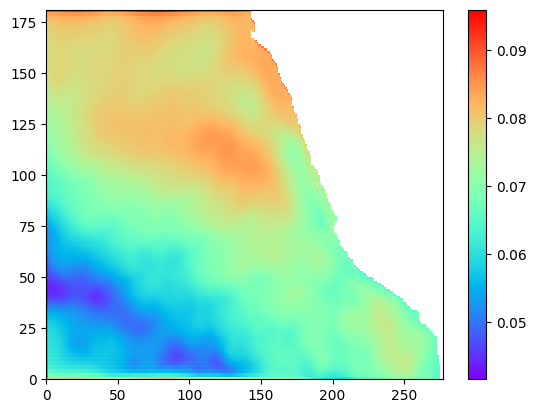

In [80]:
plt.pcolormesh(camp[:,:,9].T,cmap="rainbow")
plt.colorbar()